# Code for generating Figure 8 from derivative data, and some panels of SFig6

#### Raw code for generating derivative data is in 
`analysis5_model_traindat1dat2_richVsLazyLearning.py`
#### Batch script is in:
`analysis5_batch.sh`, line 35

#### Example command (within batch)

`python analysis5_model_traindat1dat2_richVsLazyLearning.py --weight_init 1.0 --bias_init 0 --nhidden 500 --normalize --cuda --outfilename analysis5_run${SLURM_ARRAY_TASK_ID}`

Note that weight_init needs to be varied according to parameters reported in Methods (0.2 to 2.0, in 0.2 increments)

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In this demo notebook, data for the analysis of trained ANN weights are not provided due to large file size. However, ANNs can be trained using the provided scripts.

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import dimensionality
from sklearn.decomposition import PCA

#### Set up basic parameters

In [2]:
figuredir = '../figures/Fig8/'
if not os.path.exists(figuredir): os.makedirs(figuredir)


boxpalette = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2]]
    

# Model params

In [3]:
nhidden = 500
nlayers = 10
outfilename = 'analysis5_run'
bias_init = '_biasinit0.0'
relu = ''
optim = '_optimadam'
normalize = '_normalize'
weight_init_range = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
untied = ''
nsimulations = 20

# Load RSMs & dimensionality of different initial weight conditions

In [4]:
model_rsms = []
df_dim_group = pd.DataFrame()
for weightinit in weight_init_range:
    model_rsms.append([])
    for sim in range(1,nsimulations+1):
        suffix = '_weightinit' + str(weightinit) + bias_init + optim + relu + normalize
        # Load dimensionality
        df_dim = pd.read_csv('../processed_data/analysis5_tiedweights/' + outfilename + str(sim) + '_data1and2_' + str(nhidden) + 'hidden_' + str(nlayers) + 'layers' + suffix + '_mse' + untied + '.csv')
        tmpdf = df_dim.groupby('Layer',as_index=False).mean()
        tmpdf.insert(loc=0,column='WeightInit', value=np.repeat(weightinit,12))
        tmpdf.insert(loc=0,column='Simulation', value=np.repeat(sim,12))

        df_dim_group = df_dim_group.append(tmpdf)
        
# Load in ANN RSMs    
h5f = h5py.File('../processed_data/analysis5_tiedweights/analysis5_ann_representations.h5','r')
model_rsms = h5f['data'][:].copy()
h5f.close()
        
    


# Use Visual and motor RSMs as 2 dimensions

In [5]:
vis_rsms = np.mean(np.mean(model_rsms,axis=0),axis=0)[0]
mot_rsms = np.mean(np.mean(model_rsms,axis=0),axis=0)[-1]

vis_dim = []
mot_dim = []
for weightinit in range(len(weight_init_range)):
    for sim in range(nsimulations):
        for layer in range(nlayers+2):
            vis_dim.append(np.dot(model_rsms[weightinit,sim,layer].reshape(-1),vis_rsms.reshape(-1)))
            mot_dim.append(np.dot(model_rsms[weightinit,sim,layer].reshape(-1),mot_rsms.reshape(-1)))
            
vis_dim = np.asarray(vis_dim)
mot_dim = np.asarray(mot_dim)

rsms_vismot_reduced = np.vstack((vis_dim,mot_dim)).T

#### Reshape into weight range x simulation x layer

In [6]:
rsms_dim_reduced = np.zeros((len(weight_init_range),nsimulations,nlayers+2,2))
df_rsms_dim_reduced = {}
df_rsms_dim_reduced['Weight init.'] = []
df_rsms_dim_reduced['Simulation'] = []
df_rsms_dim_reduced['Layer'] = []
df_rsms_dim_reduced['Training regime'] = []
df_rsms_dim_reduced['PC1'] = []
df_rsms_dim_reduced['PC2'] = []
i = 0
for weightinit in range(len(weight_init_range)):
    for sim in range(nsimulations):
        for layer in range(nlayers+2):
            df_rsms_dim_reduced['Weight init.'].append(weight_init_range[weightinit])
            df_rsms_dim_reduced['Simulation'].append(sim+1)
            df_rsms_dim_reduced['Layer'].append(layer)
            df_rsms_dim_reduced['PC1'].append(rsms_vismot_reduced[i,0])
            df_rsms_dim_reduced['PC2'].append(rsms_vismot_reduced[i,1])
            if weight_init_range[weightinit]<1.0:
                df_rsms_dim_reduced['Training regime'].append("Rich")
            elif weight_init_range[weightinit]>1.0:
                df_rsms_dim_reduced['Training regime'].append("Lazy")
            else:
                df_rsms_dim_reduced['Training regime'].append("1.0")
            i += 1
            
df_rsms_dim_reduced = pd.DataFrame(df_rsms_dim_reduced)


richdf = df_rsms_dim_reduced.loc[df_rsms_dim_reduced['Training regime']=='Rich']
richdf = richdf.groupby(["Simulation","Layer"]).mean()
lazydf = df_rsms_dim_reduced.loc[df_rsms_dim_reduced['Training regime']=='Lazy']
lazydf = lazydf.groupby(["Simulation","Layer"]).mean()

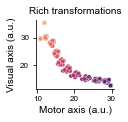

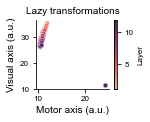

In [7]:
plt.figure(figsize=(1.8,1.8))
ax = sns.scatterplot(x="PC2", y="PC1", hue="Layer",palette='flare',data=richdf,legend=False,size=2)
ax.set_ylabel('Visual axis (a.u.)',fontsize=10)
ax.set_xlabel('Motor axis (a.u.)',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.set_title("Rich transformations",fontsize=10)
# norm = plt.Normalize(1, 12)
# sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
# sm.set_array([])
# cax = ax.figure.colorbar(sm)
# cax.ax.tick_params(labelsize=8)
# cax.ax.set_ylabel('Layer', fontsize=8);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RichRepTransformations.pdf')

plt.figure(figsize=(2.15,1.8))
ax = sns.scatterplot(x="PC2", y="PC1", hue="Layer",palette='flare',data=lazydf,legend=False,size=2)
ax.set_ylabel('Visual axis (a.u.)',fontsize=10)
ax.set_xlabel('Motor axis (a.u.)',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.set_title("Lazy transformations",fontsize=10)
norm = plt.Normalize(1, 12)
# sm = sns.cubehelix_palette()
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
cax = ax.figure.colorbar(sm)
cax.ax.tick_params(labelsize=8)
cax.ax.set_ylabel('Layer', fontsize=8);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'LazyRepTransformations.pdf')

# Plot RSMs for example rich versus lazy simulations

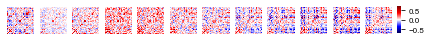

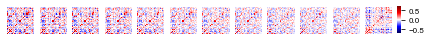

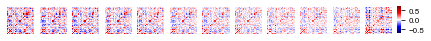

In [9]:
rich_init = 0.2
lazy_init = 2.0
intermediate = 1.0
sim_num = 0

rich_ind = np.where(np.asarray(weight_init_range)==rich_init)[0]
lazy_ind = np.where(np.asarray(weight_init_range)==lazy_init)[0]
mid_ind = np.where(np.asarray(weight_init_range)==intermediate)[0]

rich_example = np.squeeze(model_rsms[rich_ind,sim_num,:]).copy()
lazy_example = np.squeeze(model_rsms[lazy_ind,sim_num,:]).copy()
mid_example = np.squeeze(model_rsms[mid_ind,sim_num,:]).copy()

allex = np.hstack((rich_example.reshape(-1),lazy_example.reshape(-1)))
vmin = np.min(allex)
vmax = np.max(allex)

fig, axn = plt.subplots(1, nlayers+2, sharex=True, sharey=True,figsize=(6.9,2.5))
cbar_ax = fig.add_axes([.91, .43, .008, .15])
for i, ax in enumerate(axn.flat):
    ax = sns.heatmap(rich_example[i], center=0, square=True, cmap='seismic',
                ax=ax,
                cbar=i == 0,
                vmin=-0.7, vmax=0.7,
                cbar_ax=None if i else cbar_ax)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
cbar_ax.tick_params(labelsize=8)
fig.savefig('../figures/SFig6/RichRSMs.pdf',transparent=True)

fig, axn = plt.subplots(1, nlayers+2, sharex=True, sharey=True,figsize=(6.9,2.5))
cbar_ax = fig.add_axes([.91, .43, .008, .15])
for i, ax in enumerate(axn.flat):
    ax = sns.heatmap(lazy_example[i], center=0, square=True, cmap='seismic',
                ax=ax,
                cbar=i == 0,
                vmin=-0.7, vmax=0.7,
                cbar_ax=None if i else cbar_ax)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
cbar_ax.tick_params(labelsize=8)
fig.savefig('../figures/SFig6/LazyRSMs.pdf',transparent=True)

fig, axn = plt.subplots(1, nlayers+2, sharex=True, sharey=True,figsize=(6.9,2.5))
cbar_ax = fig.add_axes([.91, .43, .008, .15])
for i, ax in enumerate(axn.flat):
    ax = sns.heatmap(mid_example[i], center=0, square=True, cmap='seismic',
                ax=ax,
                cbar=i == 0,
                vmin=-0.7, vmax=0.7,
                cbar_ax=None if i else cbar_ax)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
cbar_ax.tick_params(labelsize=8)
fig.savefig('../figures/SFig6/WeightInit1_RSMs.pdf',transparent=True)

___